# Statistics and Visualisations
_Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science._
* Supervisor: Wolfgang Aussenegg
* Co-Supervisor: Sascha Hunold

Purpose of this notebook is to calculate the statistics needed, in order to answer our hypotheses in the reports

In [1]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

In [2]:
import pickle
from scipy.stats import ttest_ind
import pandas as pd
from eventstudystatistics import grank, adjBMP
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# set logging to warning
import logging
logging.getLogger().setLevel(logging.WARNING)
# unpickle the abnormal returns
df_abnormal_returns = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

EVENT_INDEX = 0

investigation_periods = settings["investigation_periods"]

day_labels = np.asarray(list(range(settings["L2"]))) - (settings["L2"]-1)/2

CAR_repr = lambda x: str([x[0]-(settings["L2"]-1)/2, x[1]-(settings["L2"]-1)/2])
CAR_periods = settings["CAR_periods"]
event_day = settings["event_day"]

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "rb") as f:
    companies = pickle.load(f)


DEBUG:matplotlib:matplotlib data path: C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\waxfa\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'nt', 'winreg', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', 'encodings.cp1252', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'ntpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', '_heapq', 'heapq', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'collections.abc', '_functools', 'functools', 'contex

### Having a look at all trade types together

In [3]:
types_of_interest = settings["types_of_interest"]
counts = df_abnormal_returns.groupby(level=2).count()[0].rename({0: "N"})
print(f"relevant filings: ",counts[types_of_interest].sum())
print(counts[types_of_interest])
print(f"dropped filings ", counts.sum() - counts[types_of_interest].sum())

relevant filings:  107589
TradeType
P - Purchase    25004
S - Sale        49049
S - Sale+OE     33536
Name: 0, dtype: int64
dropped filings  0


In [4]:
# enable multiindex slicing
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)

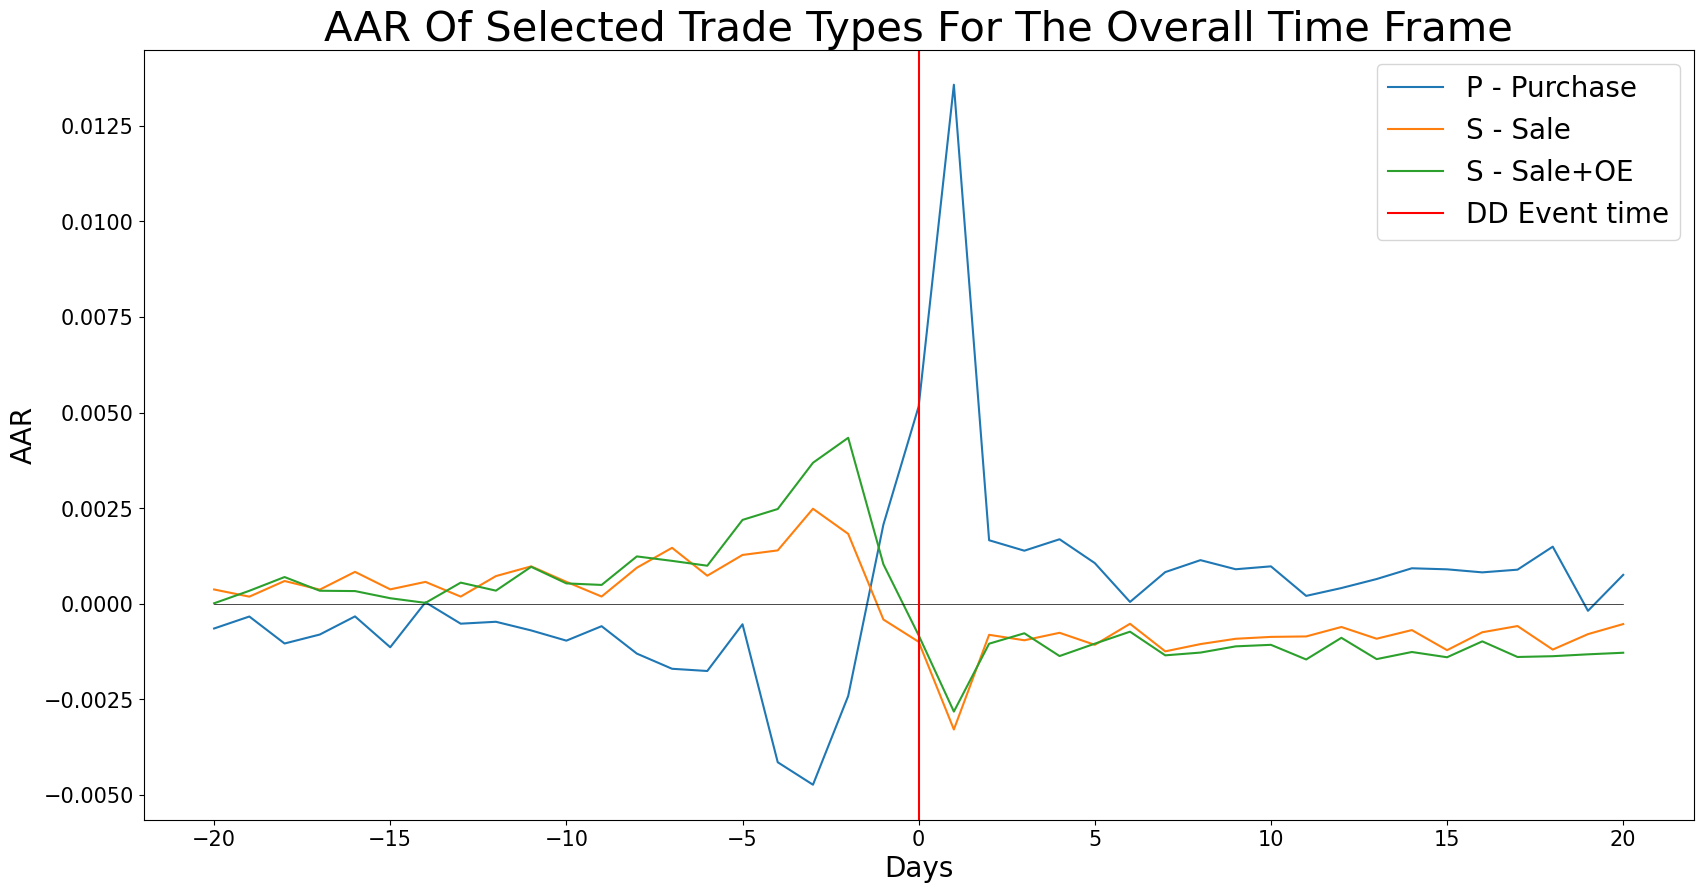

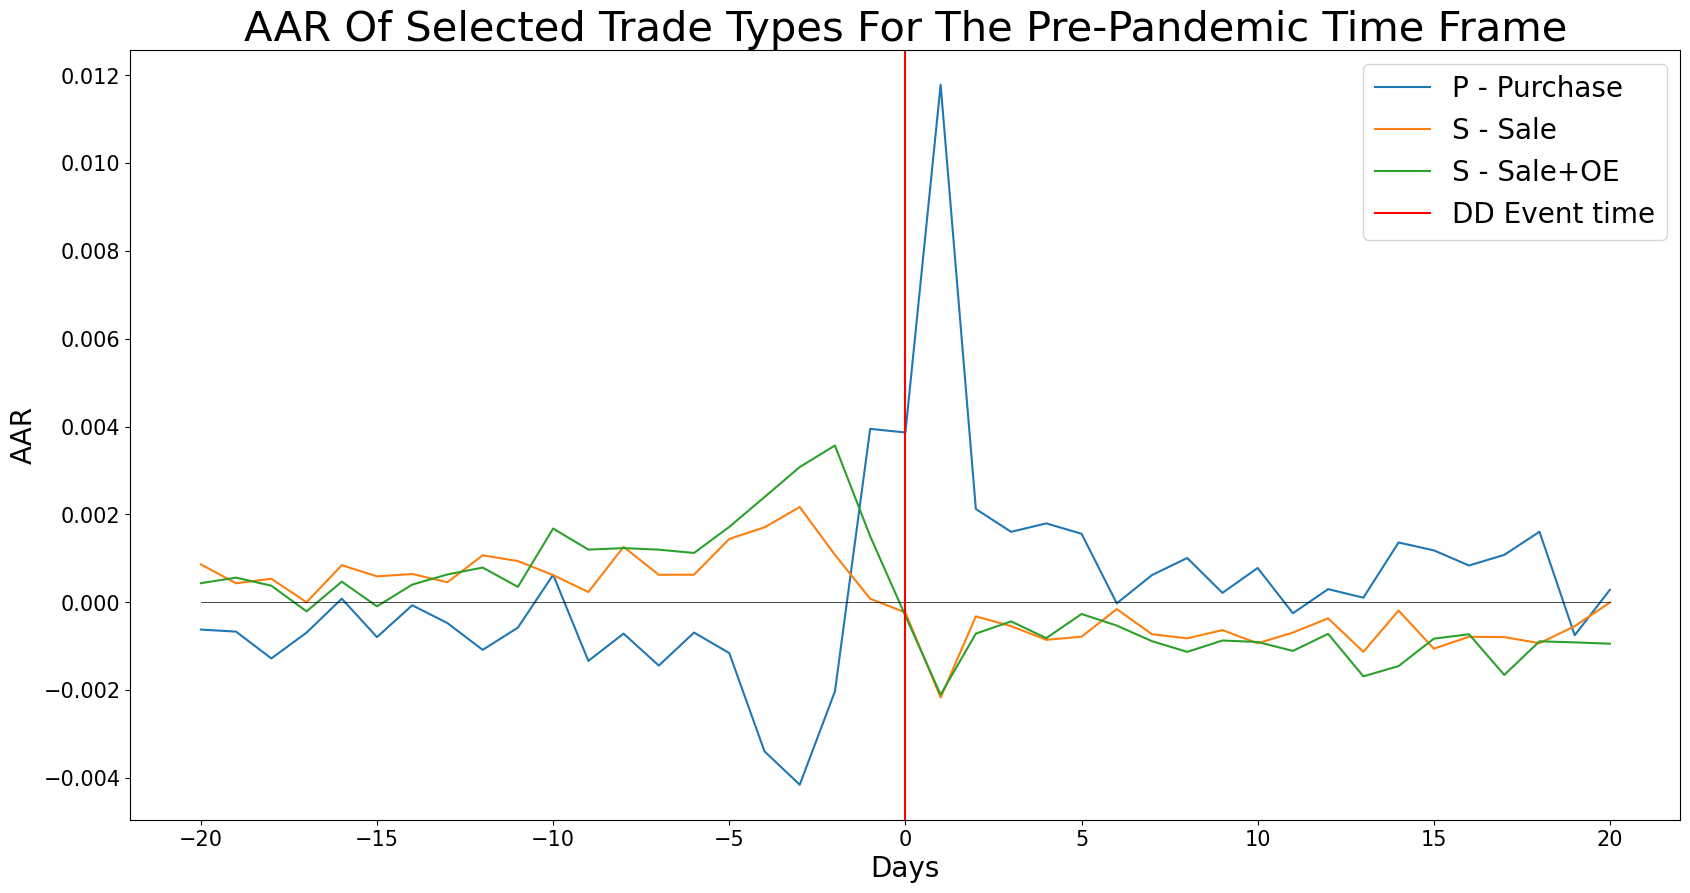

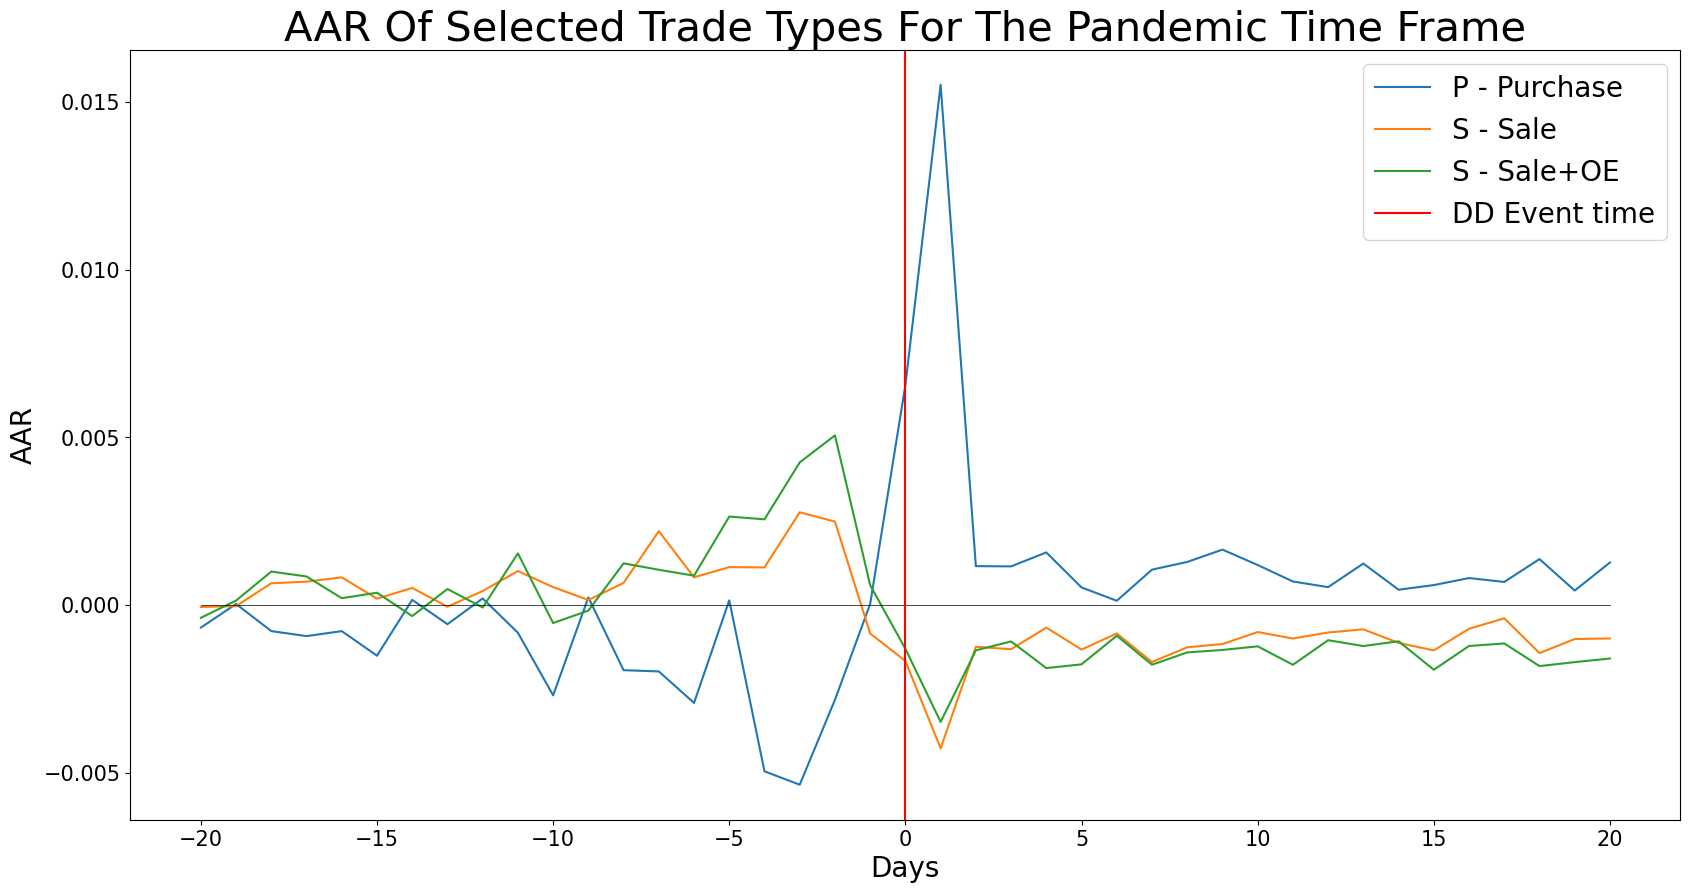

In [5]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).mean().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"AAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)

    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("AAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/AAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

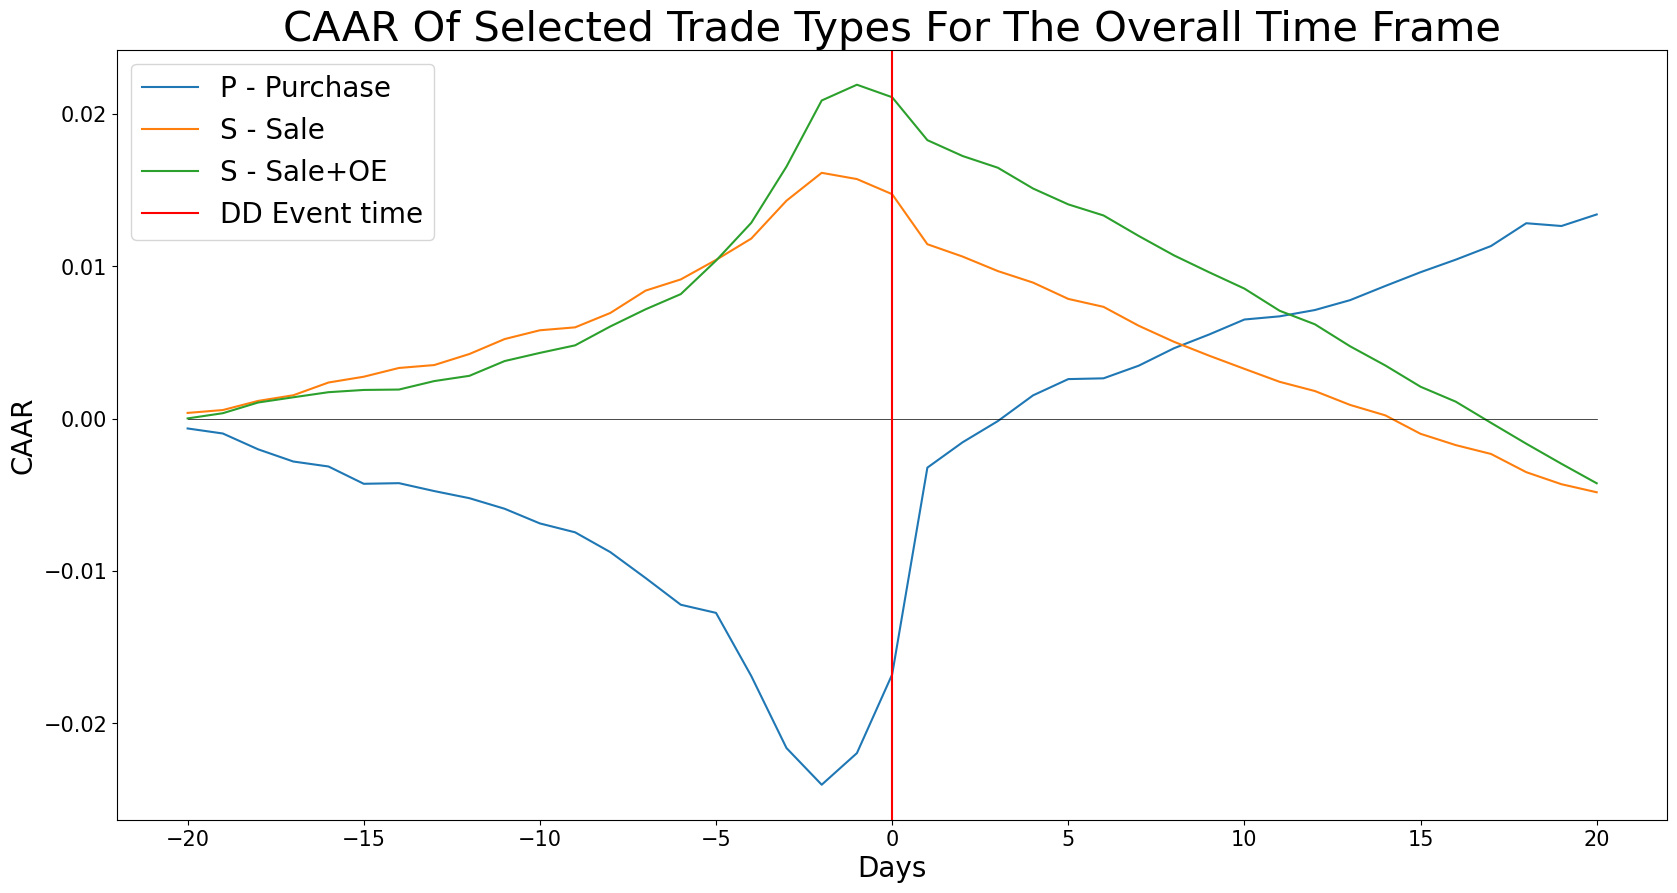

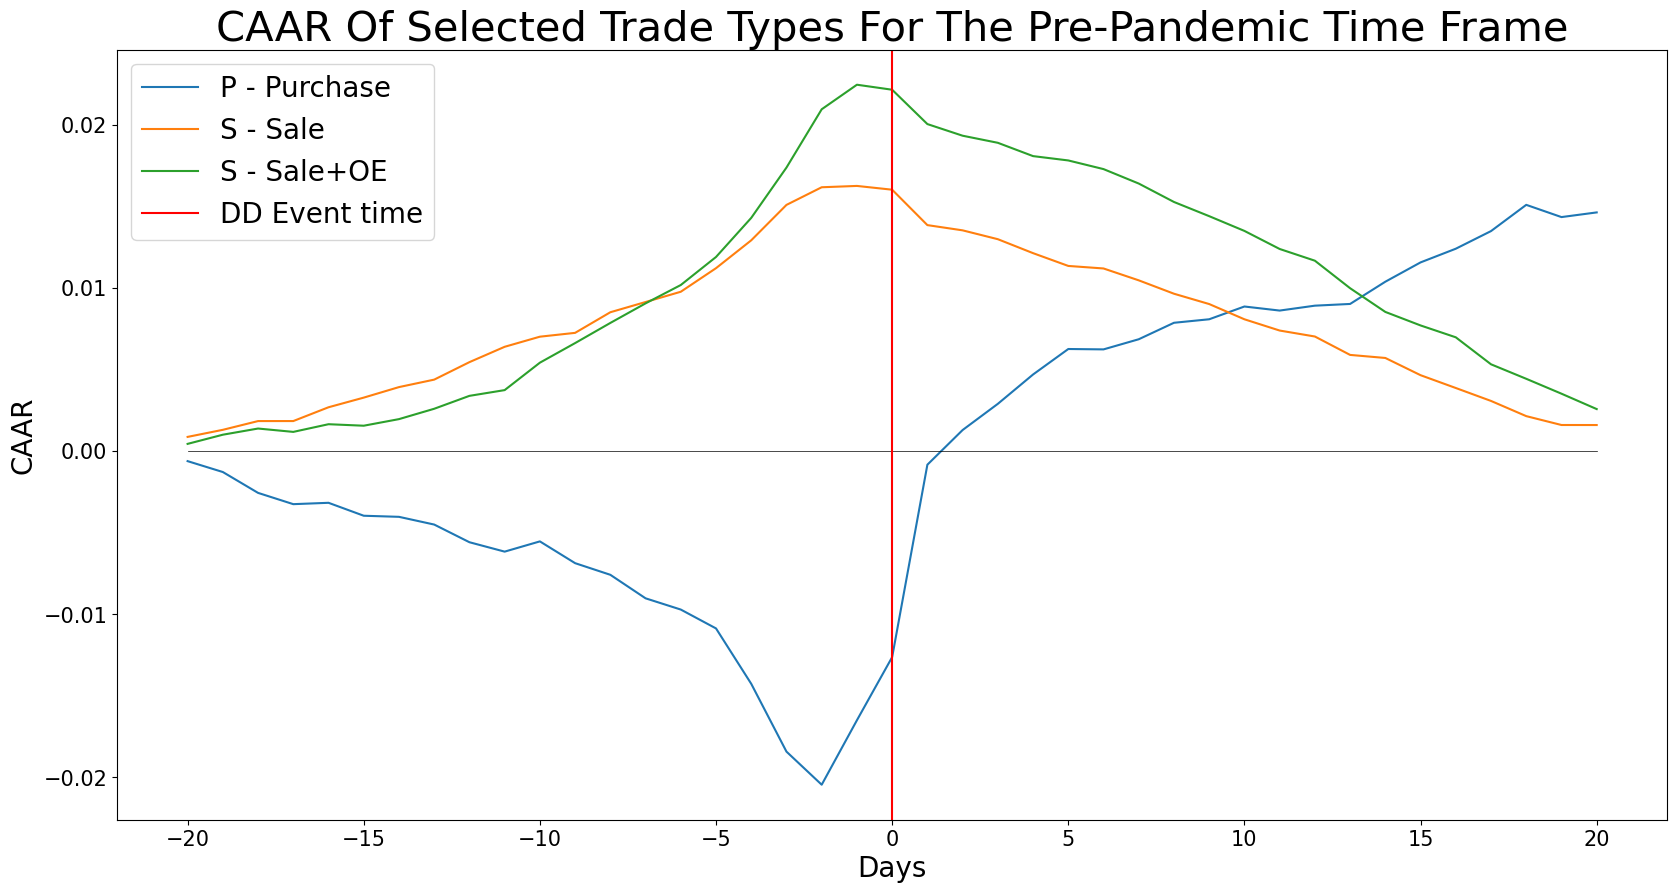

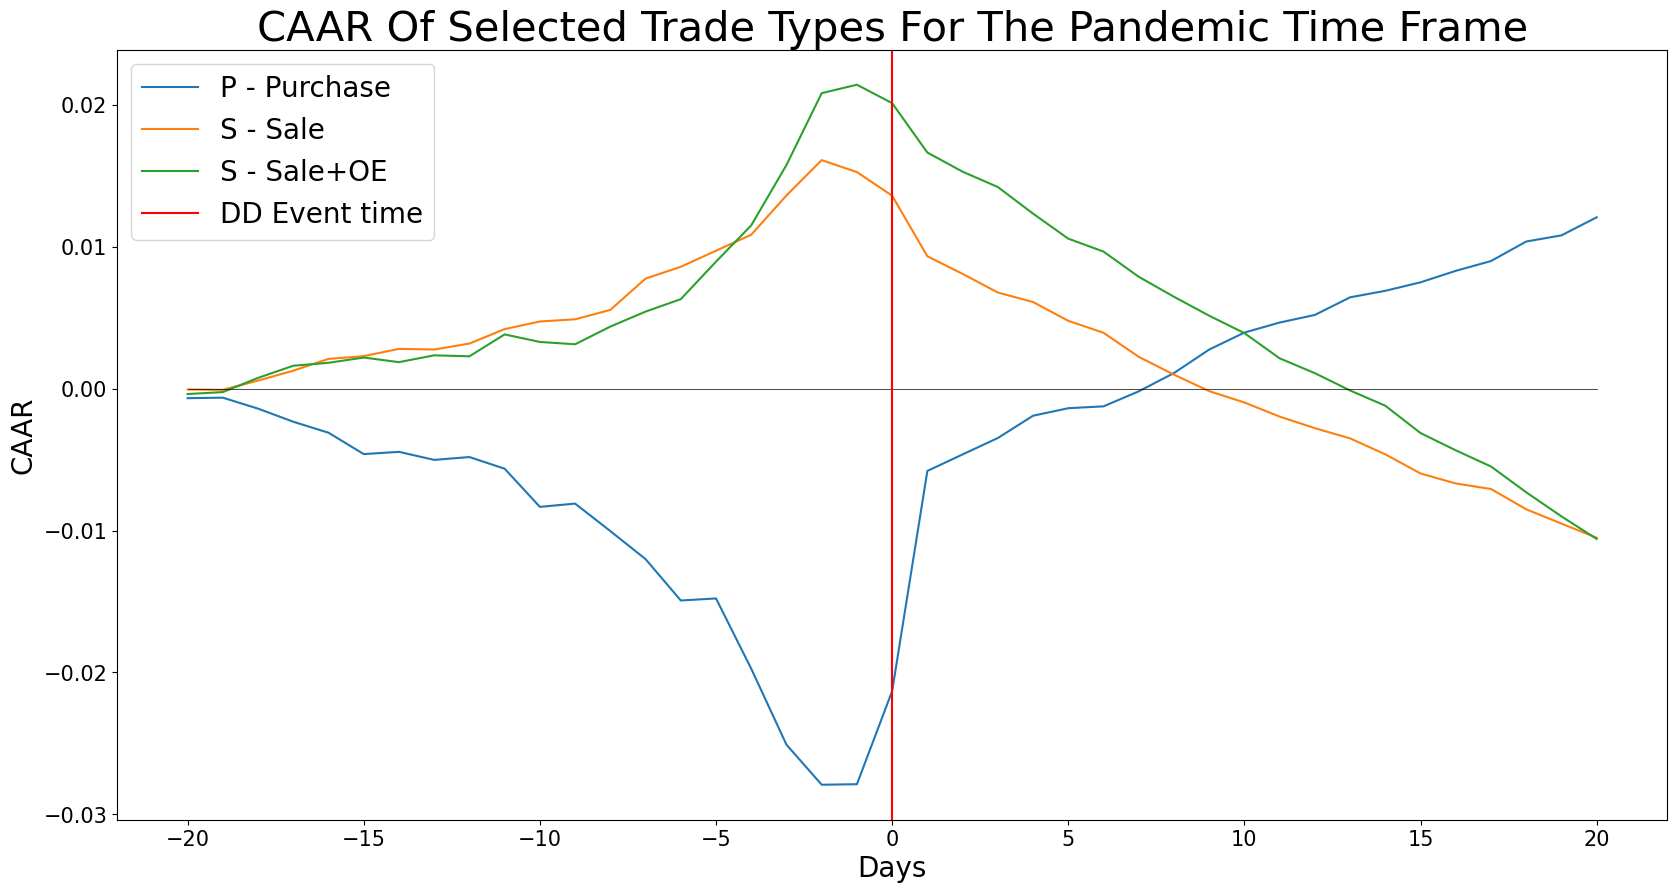

In [6]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].cumsum(axis=1).groupby(level=[2]).mean().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"CAAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("CAAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CAAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

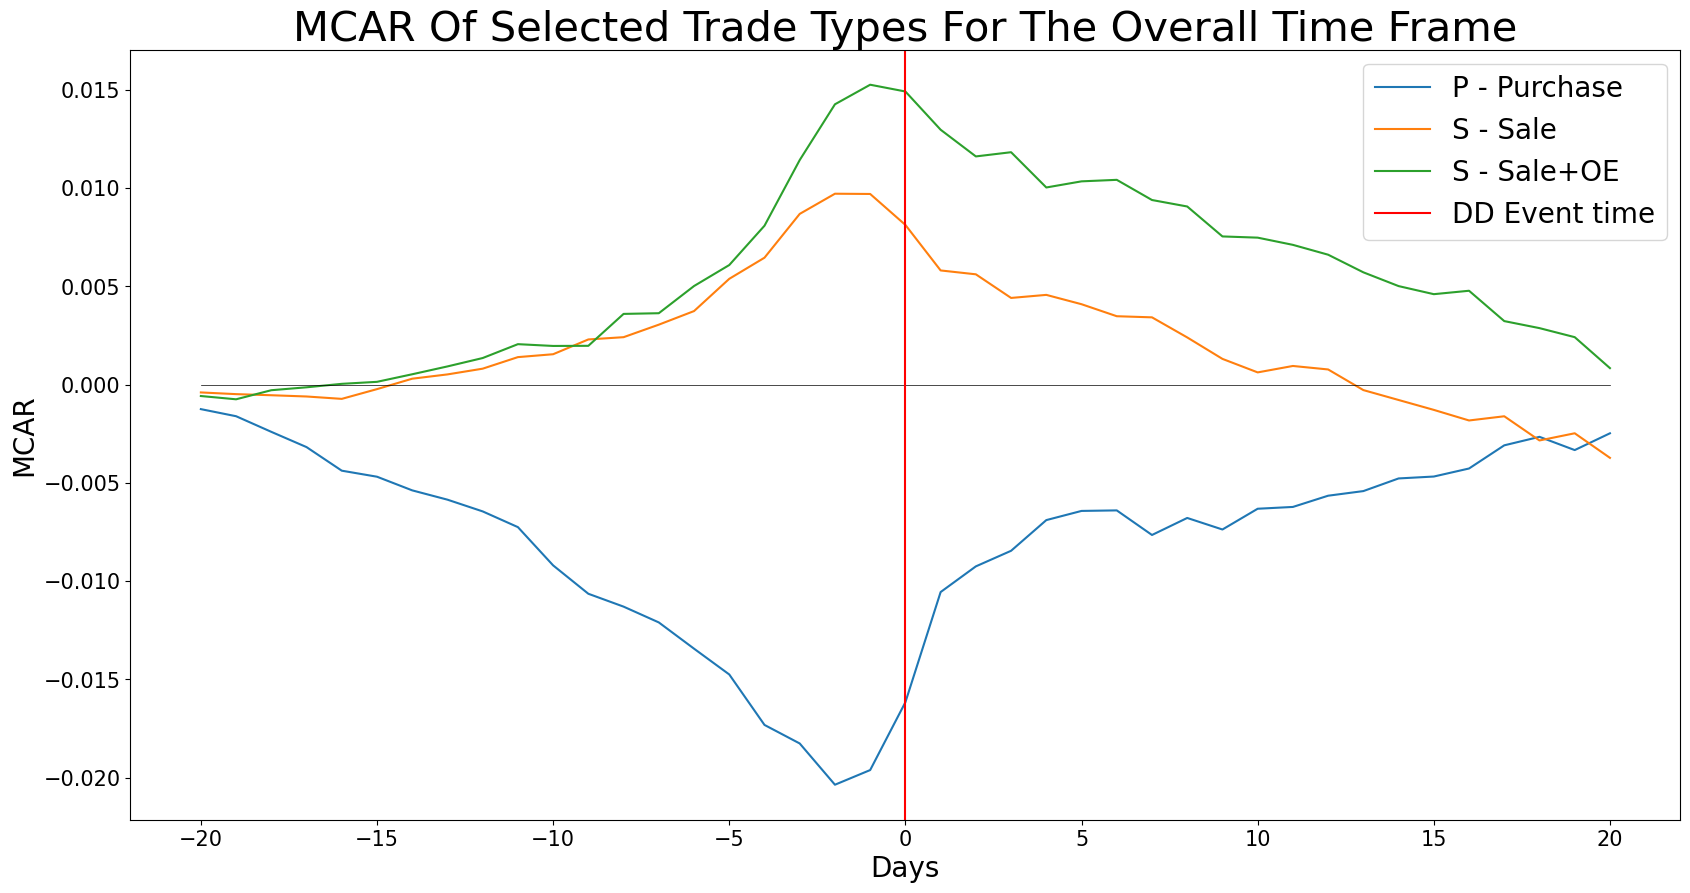

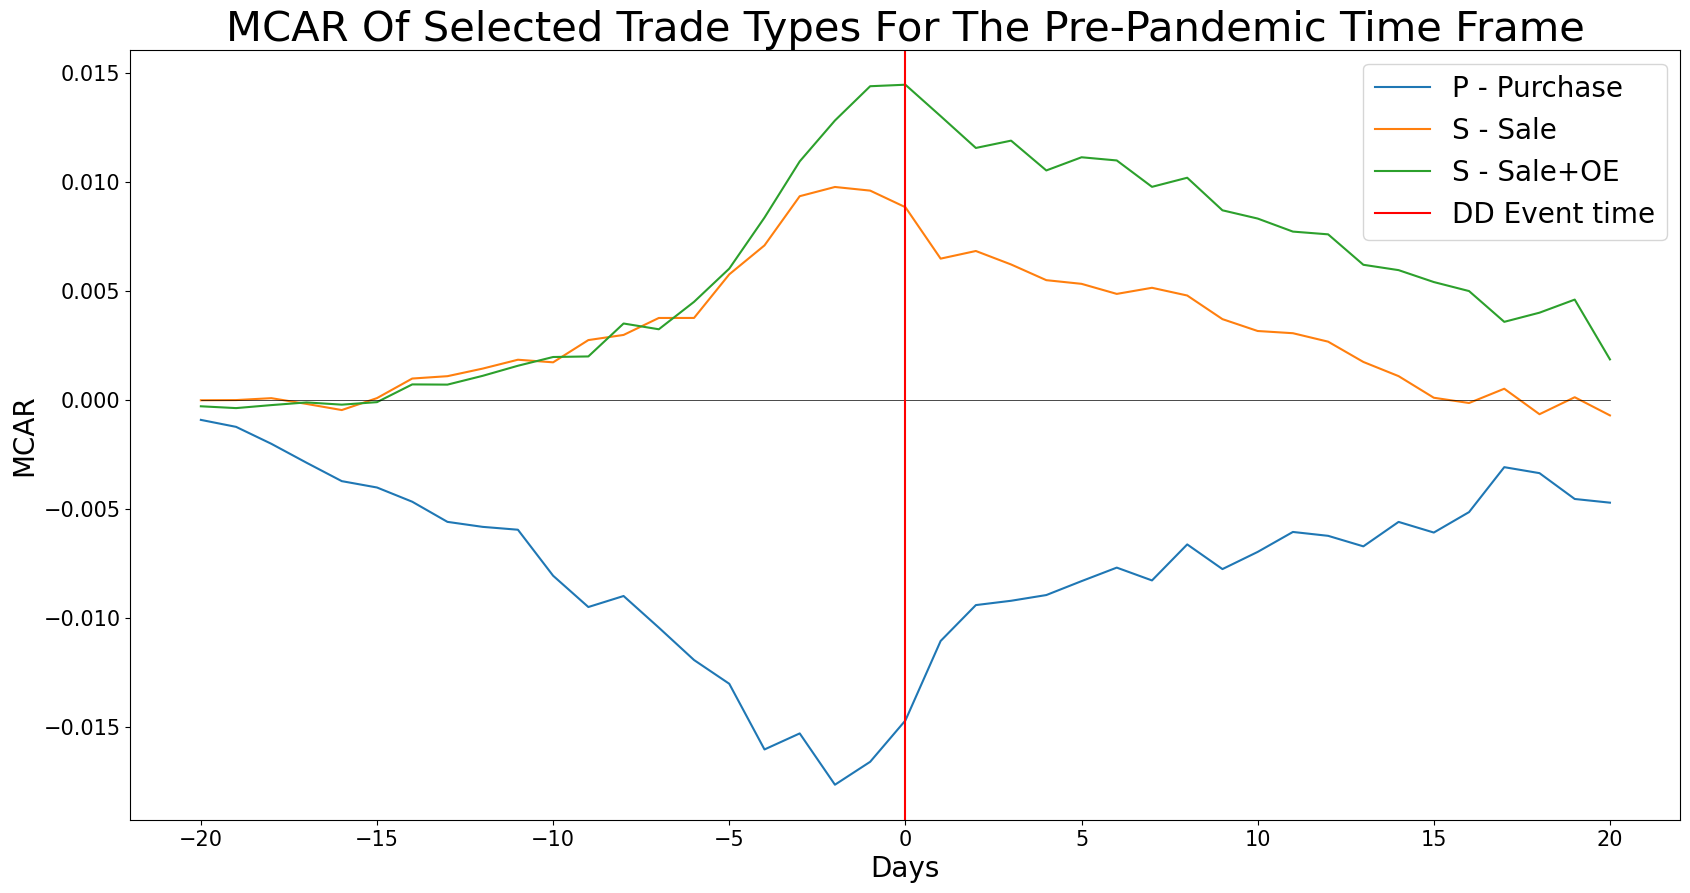

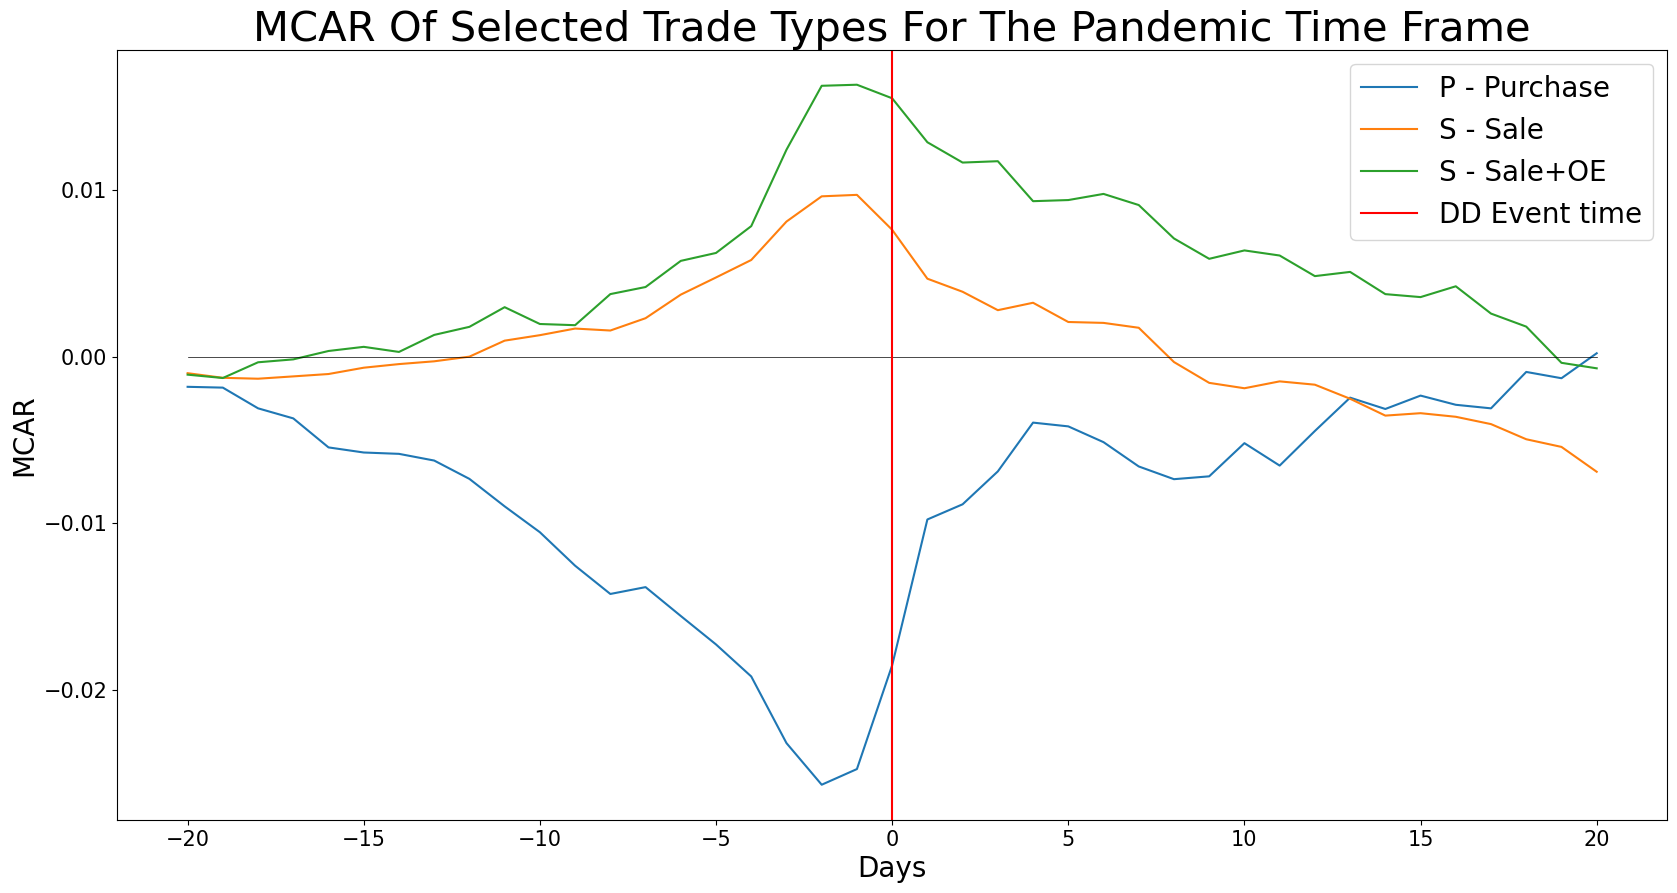

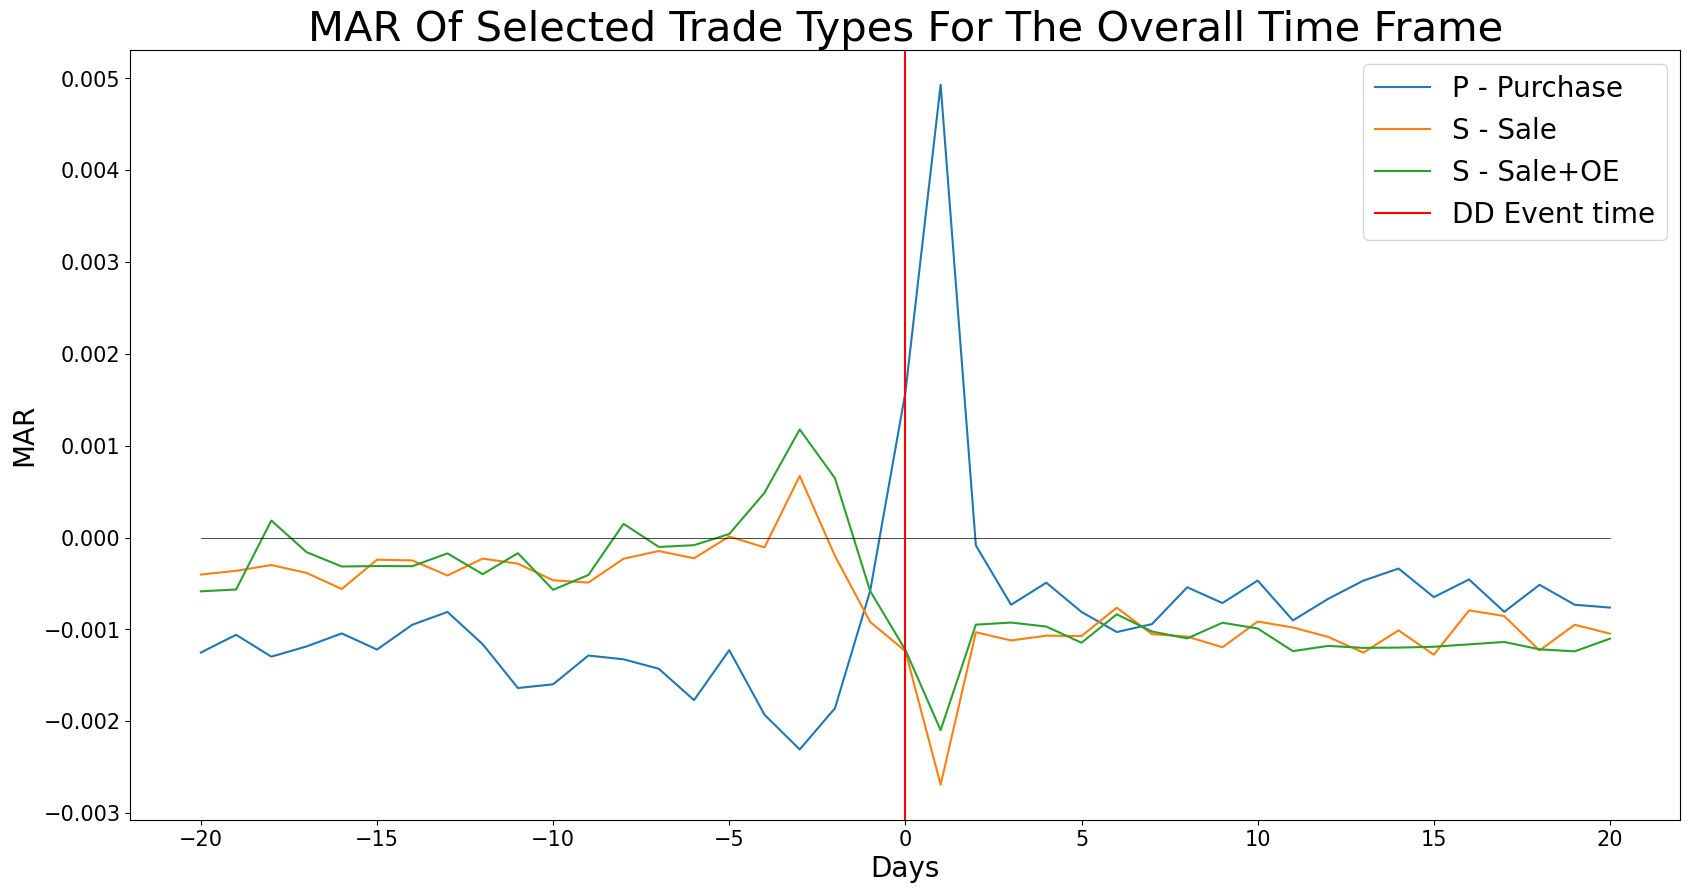

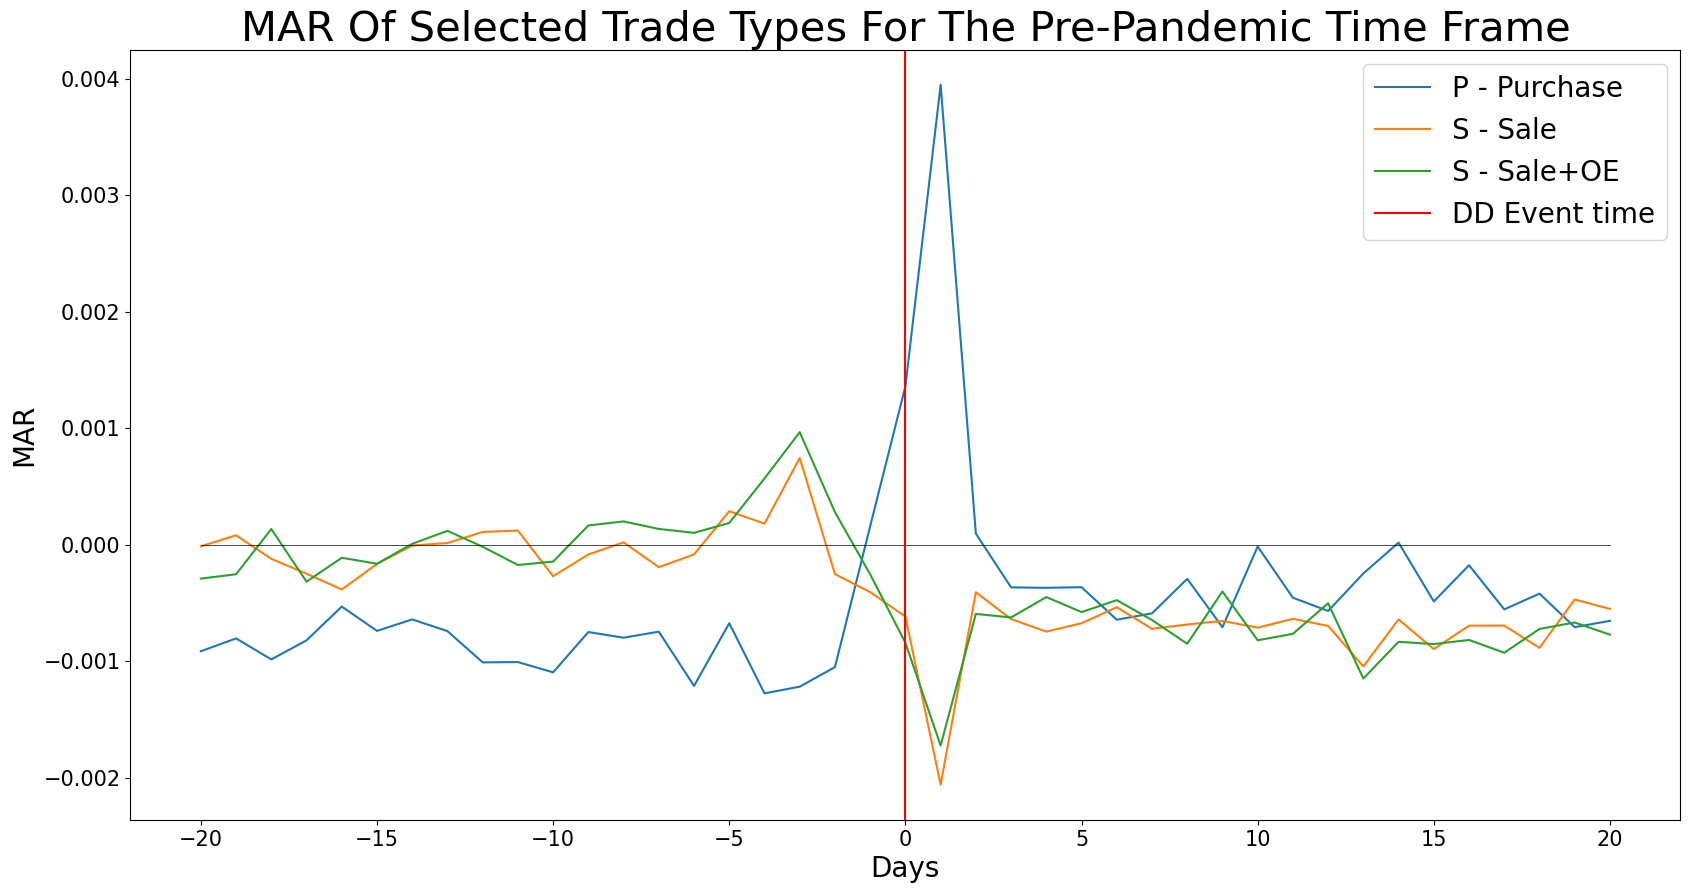

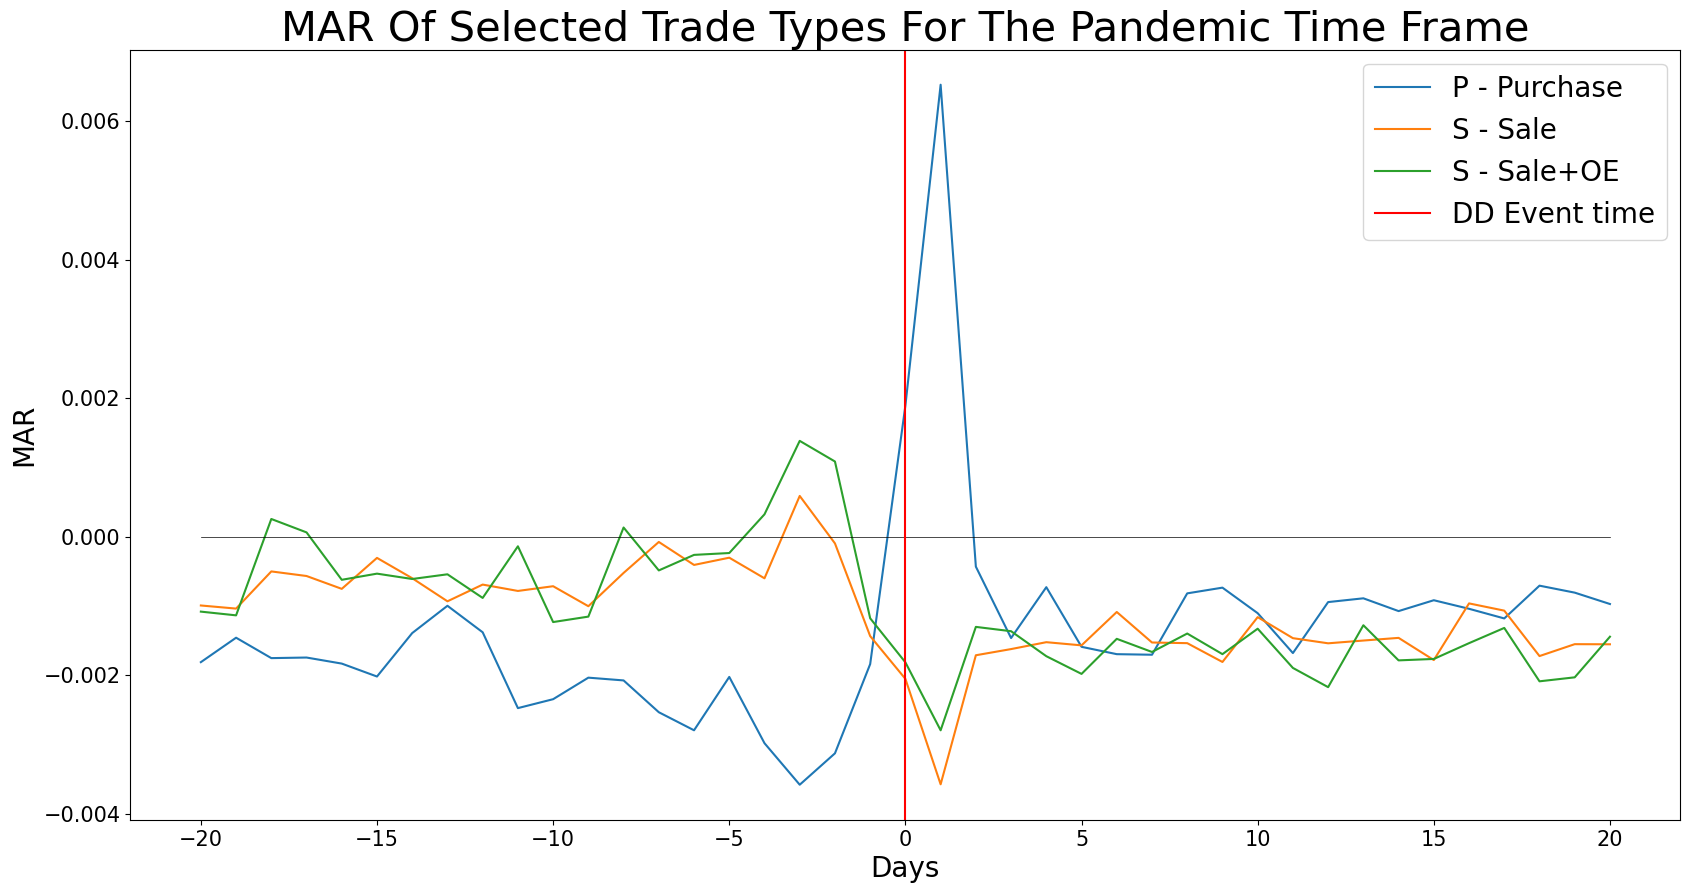

In [7]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].cumsum(axis=1).groupby(level=[2]).median().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MCAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MCAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CMAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).median().transpose().set_index(day_labels).plot(figsize=(fig_height, 10))
    plt.plot(day_labels, np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/MAR_selected_tradetypes_{investigation_period}.svg", dpi=600, bbox_inches='tight')

In [8]:
df_abnormal_returns

0         1         2   \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03      -0.010010  0.014602  0.018292   
        1 P - Purchase 2020-03-03      -0.010010  0.014602  0.018292   
        2 P - Purchase 2020-02-25      -0.023042  0.009097 -0.002792   
        3 P - Purchase 2019-10-28      -0.009376  0.010573 -0.030671   
        4 P - Purchase 2019-08-30       0.006075  0.016889 -0.019784   
...                                          ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07       0.018722  0.021104 -0.042874   
        5 P - Purchase 2018-05-31      -0.000572 -0.000392 -0.019119   
        6 P - Purchase 2018-05-02      -0.003070 -0.009494 -0.011637   
        7 P - Purchase 2018-03-23      -0.031393 -0.015181 -0.030031   
        8 P - Purchase 2018-01-03      -0.085740 -0.029176 -0.113322   

                                              3         4         5   \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03      -0.037311  0.014914 -0.003687   
        1 P - Purchase 2020-03-03      -0.037311  0.014914 -0.003687   
        2 P - Purchase 2020-02-25       0.031973 -0.004239 -0.007821   
        3 P - Purchase 2019-10-28      -0.017038  0.005934  0.006371   
        4 P - Purchase 2019-08-30       0.005841 -0.012870  0.004150   
...                                          ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07       0.029754 -0.072087  0.047655   
        5 P - Purchase 2018-05-31       0.008808 -0.129481 -0.044530   
        6 P - Purchase 2018-05-02       0.002393  0.014414  0.060491   
        7 P - Purchase 2018-03-23      -0.021668  0.004479  0.034629   
        8 P - Purchase 2018-01-03       0.017313  0.008440 -0.043747   

                                              6         7         8   \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03       0.037134  0.007239 -0.007313   
        1 P - Purchase 2020-03-03       0.037134  0.007239 -0.007313   
        2 P - Purchase 2020-02-25       0.018492  0.018459 -0.036591   
        3 P - Purchase 2019-10-28       0.040641  0.019215 -0.001585   
        4 P - Purchase 2019-08-30      -0.022081 -0.029290 -0.009721   
...                                          ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07       0.007432  0.028267 -0.238789   
        5 P - Purchase 2018-05-31       0.006852  0.056728  0.023828   
        6 P - Purchase 2018-05-02       0.017077  0.033012 -0.019536   
        7 P - Purchase 2018-03-23      -0.055589 -0.051696 -0.013868   
        8 P - Purchase 2018-01-03      -0.022290  0.047257 -0.027763   

                                              9   ...        31        32  \
Company i TradeType    event_timestamp            ...                       
AAL     0 P - Purchase 2020-03-03      -0.030570  ... -0.163283 -0.156244   
        1 P - Purchase 2020-03-03      -0.030570  ... -0.163283 -0.156244   
        2 P - Purchase 2020-02-25       0.012963  ...  0.034121 -0.019232   
        3 P - Purchase 2019-10-28      -0.009145  ... -0.036405 -0.026442   
        4 P - Purchase 2019-08-30      -0.023736  ...  0.027497  0.001505   
...                                          ...  ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07       0.008946  ... -0.010091  0.009126   
        5 P - Purchase 2018-05-31       0.011434  ... -0.013942 -0.006108   
        6 P - Purchase 2018-05-02       0.014713  ...  0.046883  0.052797   
        7 P - Purchase 2018-03-23      -0.015829  ...  0.011735  0.058119   
        8 P - Purchase 2018-01-03       0.003056  ...  0.000048  0.008298   

                                              33        34        35  \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03       0.080822 -0.005024  0.211710   
        1 P - Pur

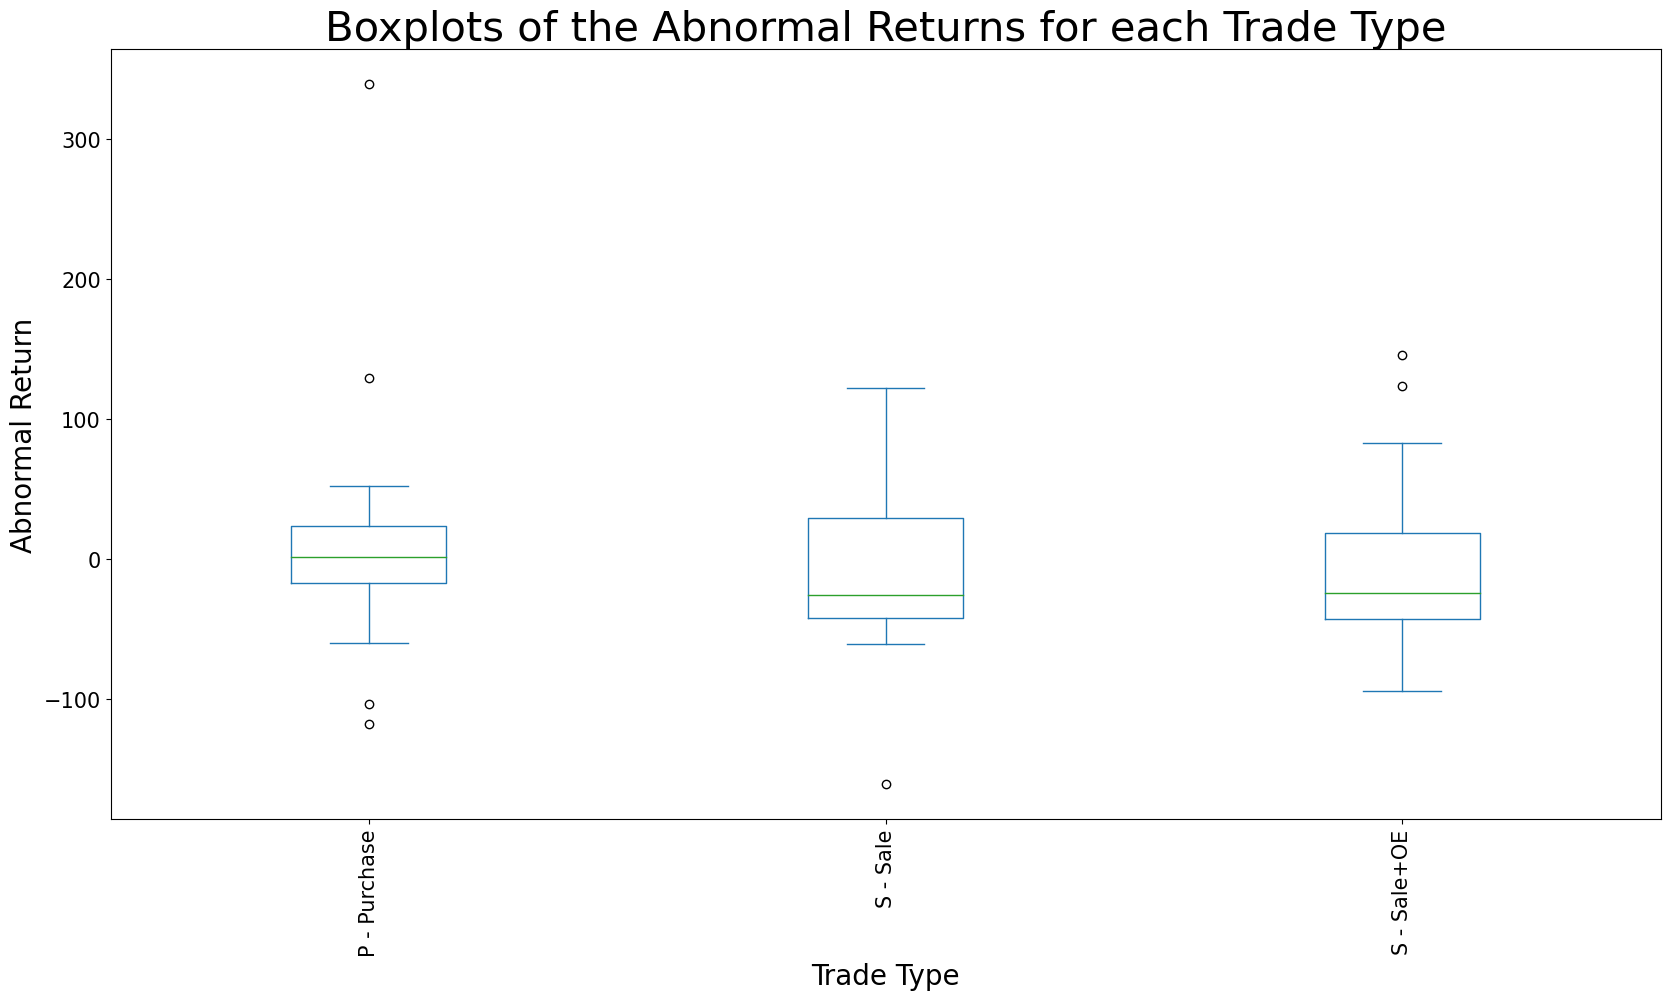

In [9]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().set_index(day_labels).plot.box(rot=90, figsize=(fig_height, 10))
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=title_size)
ax.set_xlabel("Trade Type", fontsize=label_size)
ax.set_ylabel("Abnormal Return", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.svg", dpi=600, bbox_inches='tight')

In [10]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['S - Sale', 'P - Purchase', 'S - Sale+OE']

Specify the type of the trades to investigate

In [11]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [12]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i event_timestamp                                                     
AAL     0 2020-03-03      -0.010010  0.014602  0.018292 -0.037311  0.014914   
        1 2020-03-03      -0.010010  0.014602  0.018292 -0.037311  0.014914   
        2 2020-02-25      -0.023042  0.009097 -0.002792  0.031973 -0.004239   
        3 2019-10-28      -0.009376  0.010573 -0.030671 -0.017038  0.005934   
        4 2019-08-30       0.006075  0.016889 -0.019784  0.005841 -0.012870   
...                             ...       ...       ...       ...       ...   
ZYNE    4 2018-08-07       0.018722  0.021104 -0.042874  0.029754 -0.072087   
        5 2018-05-31      -0.000572 -0.000392 -0.019119  0.008808 -0.129481   
        6 2018-05-02      -0.003070 -0.009494 -0.011637  0.002393  0.014414   
        7 2018-03-23      -0.031393 -0.015181 -0.030031 -0.021668  0.004479   
        8 2018-01-03      -0.085740 -0.029176 -0.113322  0.017313  0.008440   

                                 5         6         7         8         9   \
Company i event_timestamp                                                     
AAL     0 2020-03-03      -0.003687  0.037134  0.007239 -0.007313 -0.030570   
        1 2020-03-03      -0.003687  0.037134  0.007239 -0.007313 -0.030570   
        2 2020-02-25      -0.007821  0.018492  0.018459 -0.036591  0.012963   
        3 2019-10-28       0.006371  0.040641  0.019215 -0.001585 -0.009145   
        4 2019-08-30       0.004150 -0.022081 -0.029290 -0.009721 -0.023736   
...                             ...       ...       ...       ...       ...   
ZYNE    4 2018-08-07       0.047655  0.007432  0.028267 -0.238789  0.008946   
        5 2018-05-31      -0.044530  0.006852  0.056728  0.023828  0.011434   
        6 2018-05-02       0.060491  0.017077  0.033012 -0.019536  0.014713   
        7 2018-03-23       0.034629 -0.055589 -0.051696 -0.013868 -0.015829   
        8 2018-01-03      -0.043747 -0.022290  0.047257 -0.027763  0.003056   

                           ...        31        32        33        34  \
Company i event_timestamp  ...                                           
AAL     0 2020-03-03       ... -0.163283 -0.156244  0.080822 -0.005024   
        1 2020-03-03       ... -0.163283 -0.156244  0.080822 -0.005024   
        2 2020-02-25       ...  0.034121 -0.019232 -0.084931  0.313092   
        3 2019-10-28       ... -0.036405 -0.026442  0.006094 -0.004475   
        4 2019-08-30       ...  0.027497  0.001505 -0.009941  0.001098   
...                        ...       ...       ...       ...       ...   
ZYNE    4 2018-08-07       ... -0.010091  0.009126 -0.006430  0.020222   
        5 2018-05-31       ... -0.013942 -0.006108 -0.026237  0.089463   
        6 2018-05-02       ...  0.046883  0.052797 -0.032499  0.039374   
        7 2018-03-23       ...  0.011735  0.058119  0.014532  0.030655   
        8 2018-01-03       ...  0.000048  0.008298 -0.030083  0.028617   

                                 35        36        37        38        39  \
Company i event_timestamp                                                     
AAL     0 2020-03-03       0.211710  0.116594 -0.082424 -0.031342 -0.191482   
        1 2020-03-03       0.211710  0.116594 -0.082424 -0.031342 -0.191482   
        2 2020-02-25      -0.120007 -0.174589 -0.151899  0.071579 -0.006438   
        3 2019-10-28      -0.008409  0.022899 -0.027790 -0.005418  0.026726   
        4 2019-08-30      -0.015156  0.002783  0.003953  0.000137  0.009878   
...                             ...       ...       ...       ...       ...   
ZYNE    4 2018-08-07       0.051008  0.168674  0.007592 -0.000995  0.014532   
        5 2018-05-31       0.051694 -0.062224 -0.075411  0.040058 -0.092464   
        6 2018-05-02       0.004273 -0.031825  0.006298  0.016867 -0.012485   
        7 2018-03-23      -0.022042  0.012075 -0.036748  0.041524  0.034871   
        8 2018-01-03      -0.008970  0.048463  0.058014 -0.031614 

In [13]:
df_abnormal_returns.loc[:,:, types_of_interest].groupby(level=[2]).count()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TradeType,,,,,,,,,,,,,,,,,,,,,
P - Purchase,25004,25004,25004,25004,25004,25004,25004,25004,25004,25004,...,25004,25004,25004,25004,25004,25004,25004,25004,25004,25004
S - Sale,49049,49049,49049,49049,49049,49049,49049,49049,49049,49049,...,49049,49049,49049,49049,49049,49049,49049,49049,49049,49049
S - Sale+OE,33536,33536,33536,33536,33536,33536,33536,33536,33536,33536,...,33536,33536,33536,33536,33536,33536,33536,33536,33536,33536


In [14]:
CAR = df_abnormal_returns.cumsum(axis =1).loc[:,:, types_of_interest]
CAR

0         1         2   \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03      -0.010010  0.004593  0.022884   
        1 P - Purchase 2020-03-03      -0.010010  0.004593  0.022884   
        2 P - Purchase 2020-02-25      -0.023042 -0.013945 -0.016737   
        3 P - Purchase 2019-10-28      -0.009376  0.001197 -0.029474   
        4 P - Purchase 2019-08-30       0.006075  0.022964  0.003180   
...                                          ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07       0.018722  0.039826 -0.003048   
        5 P - Purchase 2018-05-31      -0.000572 -0.000964 -0.020084   
        6 P - Purchase 2018-05-02      -0.003070 -0.012564 -0.024201   
        7 P - Purchase 2018-03-23      -0.031393 -0.046574 -0.076605   
        8 P - Purchase 2018-01-03      -0.085740 -0.114917 -0.228239   

                                              3         4         5   \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03      -0.014427  0.000487 -0.003200   
        1 P - Purchase 2020-03-03      -0.014427  0.000487 -0.003200   
        2 P - Purchase 2020-02-25       0.015236  0.010996  0.003175   
        3 P - Purchase 2019-10-28      -0.046513 -0.040579 -0.034207   
        4 P - Purchase 2019-08-30       0.009020 -0.003850  0.000300   
...                                          ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07       0.026706 -0.045381  0.002274   
        5 P - Purchase 2018-05-31      -0.011276 -0.140758 -0.185288   
        6 P - Purchase 2018-05-02      -0.021808 -0.007394  0.053097   
        7 P - Purchase 2018-03-23      -0.098273 -0.093794 -0.059165   
        8 P - Purchase 2018-01-03      -0.210926 -0.202486 -0.246233   

                                              6         7         8   \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03       0.033934  0.041174  0.033861   
        1 P - Purchase 2020-03-03       0.033934  0.041174  0.033861   
        2 P - Purchase 2020-02-25       0.021667  0.040126  0.003535   
        3 P - Purchase 2019-10-28       0.006434  0.025649  0.024064   
        4 P - Purchase 2019-08-30      -0.021780 -0.051070 -0.060791   
...                                          ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07       0.009706  0.037973 -0.200816   
        5 P - Purchase 2018-05-31      -0.178436 -0.121708 -0.097880   
        6 P - Purchase 2018-05-02       0.070174  0.103187  0.083651   
        7 P - Purchase 2018-03-23      -0.114753 -0.166449 -0.180318   
        8 P - Purchase 2018-01-03      -0.268523 -0.221265 -0.249029   

                                              9   ...        31        32  \
Company i TradeType    event_timestamp            ...                       
AAL     0 P - Purchase 2020-03-03       0.003291  ... -0.201691 -0.357935   
        1 P - Purchase 2020-03-03       0.003291  ... -0.201691 -0.357935   
        2 P - Purchase 2020-02-25       0.016498  ... -0.183543 -0.202775   
        3 P - Purchase 2019-10-28       0.014919  ...  0.073283  0.046841   
        4 P - Purchase 2019-08-30      -0.084527  ...  0.002382  0.003887   
...                                          ...  ...       ...       ...   
ZYNE    4 P - Purchase 2018-08-07      -0.191870  ... -0.390692 -0.381566   
        5 P - Purchase 2018-05-31      -0.086445  ...  0.099252  0.093144   
        6 P - Purchase 2018-05-02       0.098364  ...  0.083246  0.136043   
        7 P - Purchase 2018-03-23      -0.196146  ... -0.135389 -0.077270   
        8 P - Purchase 2018-01-03      -0.245973  ... -0.278463 -0.270165   

                                              33        34        35  \
Company i TradeType    event_timestamp                                 
AAL     0 P - Purchase 2020-03-03      -0.277113 -0.282138 -0.070427   
        1 P - Pur

In [15]:
CAR[CAR.isnull().any(axis=1)]

,,,,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Company,i,TradeType,event_timestamp,,,,,,,,,,,,,,,,,,,,,


In [16]:
# Temp fix to make the rest work
##CAR = CAR[CAR.isnull().any(axis=1) == False]
##CAR
df_abnormal_returns[df_abnormal_returns.isnull().any(axis=1)]

,,,,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
Company,i,TradeType,event_timestamp,,,,,,,,,,,,,,,,,,,,,


In [17]:
# aggregate on time axis
CAAR = CAR.groupby(level=[2]).mean().transpose()
print(CAAR.describe().to_latex())

\begin{tabular}{lrrr}
\toprule
TradeType &  P - Purchase &   S - Sale &  S - Sale+OE \\
\midrule
count &     41.000000 &  41.000000 &    41.000000 \\
mean  &     -0.001737 &   0.005038 &     0.007378 \\
std   &      0.009893 &   0.005458 &     0.007074 \\
min   &     -0.024023 &  -0.004831 &    -0.004240 \\
25\%   &     -0.006876 &   0.001163 &     0.001884 \\
50\%   &     -0.001551 &   0.004243 &     0.006051 \\
75\%   &      0.006506 &   0.008928 &     0.012849 \\
max   &      0.013401 &   0.016133 &     0.021914 \\
\bottomrule
\end{tabular}



C:\Users\waxfa\AppData\Local\Temp\ipykernel_29516\2729430084.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(CAAR.describe().to_latex())


In [18]:
# aggregate on filings axis
results = []
index_stats = []
for type_ in types_of_interest:
    for ip in investigation_periods:
        for cp in CAR_periods:
            l, r = investigation_periods[ip]
            l_CAR, r_CAR = CAR_periods[cp]
            CAR = df_abnormal_returns.iloc[:,l_CAR:(r_CAR+1)].sum(axis =1).loc[:,:, types_of_interest]
            res = CAR.loc[:,:,type_,l:r].groupby(level=[2]).describe().transpose()
            res = res.round(4)
            res.loc["count"] = res.loc["count"].astype(int).astype(str)
            results.append(res.transpose())
            index_stats.append((type_, ip, cp))

In [19]:
stats_df = pd.concat(results)
stats_df.index = pd.MultiIndex.from_tuples(index_stats, names=["Trade Type", "Investigation Period", "CAR period"])
print(stats_df.to_latex())

\begin{tabular}{lllllllllll}
\toprule
            &          &        &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
Trade Type & Investigation Period & CAR period &        &         &         &         &         &         &         &         \\
\midrule
P - Purchase & Overall & [-20, -1] &  25004 & -0.0219 &  0.2473 & -2.9595 & -0.1135 & -0.0196 &  0.0622 &  9.1958 \\
            &          & [0, 20] &  25004 &  0.0353 &   0.203 &  -3.344 &  -0.053 &  0.0169 &  0.1053 &  6.2641 \\
            &          & [0, 5] &  25004 &  0.0245 &  0.1261 & -1.1391 & -0.0253 &   0.011 &  0.0622 &  3.5077 \\
            &          & [0, 1] &  25004 &  0.0187 &  0.0778 & -0.7665 & -0.0135 &  0.0082 &  0.0401 &  1.6016 \\
            & Pre-Pandemic & [-20, -1] &  13024 & -0.0165 &  0.2305 & -1.5572 & -0.0959 & -0.0166 &  0.0552 &  3.9993 \\
            &          & [0, 20] &  13024 &  0.0311 &  0.1964 & -1.6037 & -0.0507 &  0.0111 &  0.0886 &  6.2641 \\
           

C:\Users\waxfa\AppData\Local\Temp\ipykernel_29516\2457059172.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df.to_latex())


In [20]:
CAR = df_abnormal_returns.cumsum(axis =1).loc[:,:, types_of_interest]

# Statistics


In [21]:
# unpickle the data
df_eps = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")
df_estimation_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")

df_eps.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_estimation_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_event_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)


In [22]:
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
left, right = investigation_periods["Pandemic"]
df_abnormal_returns.loc[:,:,type_, left:right]

0         1         2   \
Company i  TradeType   event_timestamp                                 
AAON    1  S - Sale+OE 2021-12-07       0.011048  0.028275  0.012262   
        2  S - Sale+OE 2021-12-03       0.011574 -0.002915  0.011233   
        3  S - Sale+OE 2021-12-03       0.011574 -0.002915  0.011233   
        5  S - Sale+OE 2021-12-02       0.003267  0.011931 -0.002691   
        6  S - Sale+OE 2021-11-24      -0.012041  0.024664 -0.000573   
...                                          ...       ...       ...   
ZUMZ    32 S - Sale+OE 2020-12-02       0.014210 -0.049046  0.036104   
        33 S - Sale+OE 2020-12-02       0.014210 -0.049046  0.036104   
        35 S - Sale+OE 2020-11-30      -0.027874  0.047642  0.014769   
        36 S - Sale+OE 2020-11-30      -0.027874  0.047642  0.014769   
        42 S - Sale+OE 2020-09-15       0.021715 -0.062935 -0.022693   

                                              3         4         5   \
Company i  TradeType   event_timestamp                                 
AAON    1  S - Sale+OE 2021-12-07      -0.005338  0.002526 -0.010049   
        2  S - Sale+OE 2021-12-03       0.028394  0.012274 -0.005107   
        3  S - Sale+OE 2021-12-03       0.028394  0.012274 -0.005107   
        5  S - Sale+OE 2021-12-02       0.011425  0.028440  0.012088   
        6  S - Sale+OE 2021-11-24       0.007484 -0.011025  0.004088   
...                                          ...       ...       ...   
ZUMZ    32 S - Sale+OE 2020-12-02      -0.020297  0.177884 -0.005215   
        33 S - Sale+OE 2020-12-02      -0.020297  0.177884 -0.005215   
        35 S - Sale+OE 2020-11-30      -0.049217  0.036391 -0.019083   
        36 S - Sale+OE 2020-11-30      -0.049217  0.036391 -0.019083   
        42 S - Sale+OE 2020-09-15      -0.022998  0.014856  0.034887   

                                              6         7         8   \
Company i  TradeType   event_timestamp                                 
AAON    1  S - Sale+OE 2021-12-07      -0.001835 -0.008782 -0.000289   
        2  S - Sale+OE 2021-12-03       0.002805 -0.009874 -0.001581   
        3  S - Sale+OE 2021-12-03       0.002805 -0.009874 -0.001581   
        5  S - Sale+OE 2021-12-02      -0.004815  0.003202 -0.009706   
        6  S - Sale+OE 2021-11-24       0.012601 -0.002449  0.011567   
...                                          ...       ...       ...   
ZUMZ    32 S - Sale+OE 2020-12-02      -0.053841 -0.037484  0.009436   
        33 S - Sale+OE 2020-12-02      -0.053841 -0.037484  0.009436   
        35 S - Sale+OE 2020-11-30       0.179672 -0.003486 -0.053341   
        36 S - Sale+OE 2020-11-30       0.179672 -0.003486 -0.053341   
        42 S - Sale+OE 2020-09-15       0.022765  0.027239  0.022996   

                                              9   ...        31        32  \
Company i  TradeType   event_timestamp            ...                       
AAON    1  S - Sale+OE 2021-12-07       0.007172  ... -0.000455 -0.007295   
        2  S - Sale+OE 2021-12-03      -0.008634  ... -0.002879 -0.006275   
        3  S - Sale+OE 2021-12-03      -0.008634  ... -0.002879 -0.006275   
        5  S - Sale+OE 2021-12-02      -0.001237  ...  0.006269 -0.002975   
        6  S - Sale+OE 2021-11-24       0.028116  ... -0.001487  0.015562   
...                                          ...  ...       ...       ...   
ZUMZ    32 S - Sale+OE 2020-12-02       0.024339  ...  0.015132 -0.014117   
        33 S - Sale+OE 2020-12-02       0.024339  ...  0.015132 -0.014117   
        35 S - Sale+OE 2020-11-30      -0.036013  ...  0.008959 -0.013656   
        36 S - Sale+OE 2020-11-30      -0.036013  ...  0.008959 -0.013656   
        42 S - Sale+OE 2020-09-15      -0.028458  ... -0.000420 -0.015044   

                                              33        34        35  \
Company i  TradeType   event_timestamp                                 
AAON    1  S - Sale+OE 2021-12-07       0.004924 -0.002451  0.004475   
        2  S - Sa

In [23]:
# temporary cell to show data to professor
CAR_period = CAR_periods["[0, 5]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pandemic"]
AR = df_abnormal_returns.loc[:,:,type_, left:right].values
eps = df_eps.loc[:,:,type_,left:right].values
R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
# pickle tuple
with open(f"data/{NAME}/adj-bmp_test.pkl", "wb") as f:
    pickle.dump((AR, eps, R_market_estimation_window, R_market_event_window, CAR_period), f)


Too many events to calculate average cross correlation, subsampling combinations...


In [24]:
# P-purchases pre-event (-20,-1).
CAR_period = CAR_periods["[-20, -1]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pre-Pandemic"]
CAR_ = CAR.loc[:,:,type_, left:right].values
np.median(CAR_)

-0.006325974313422201

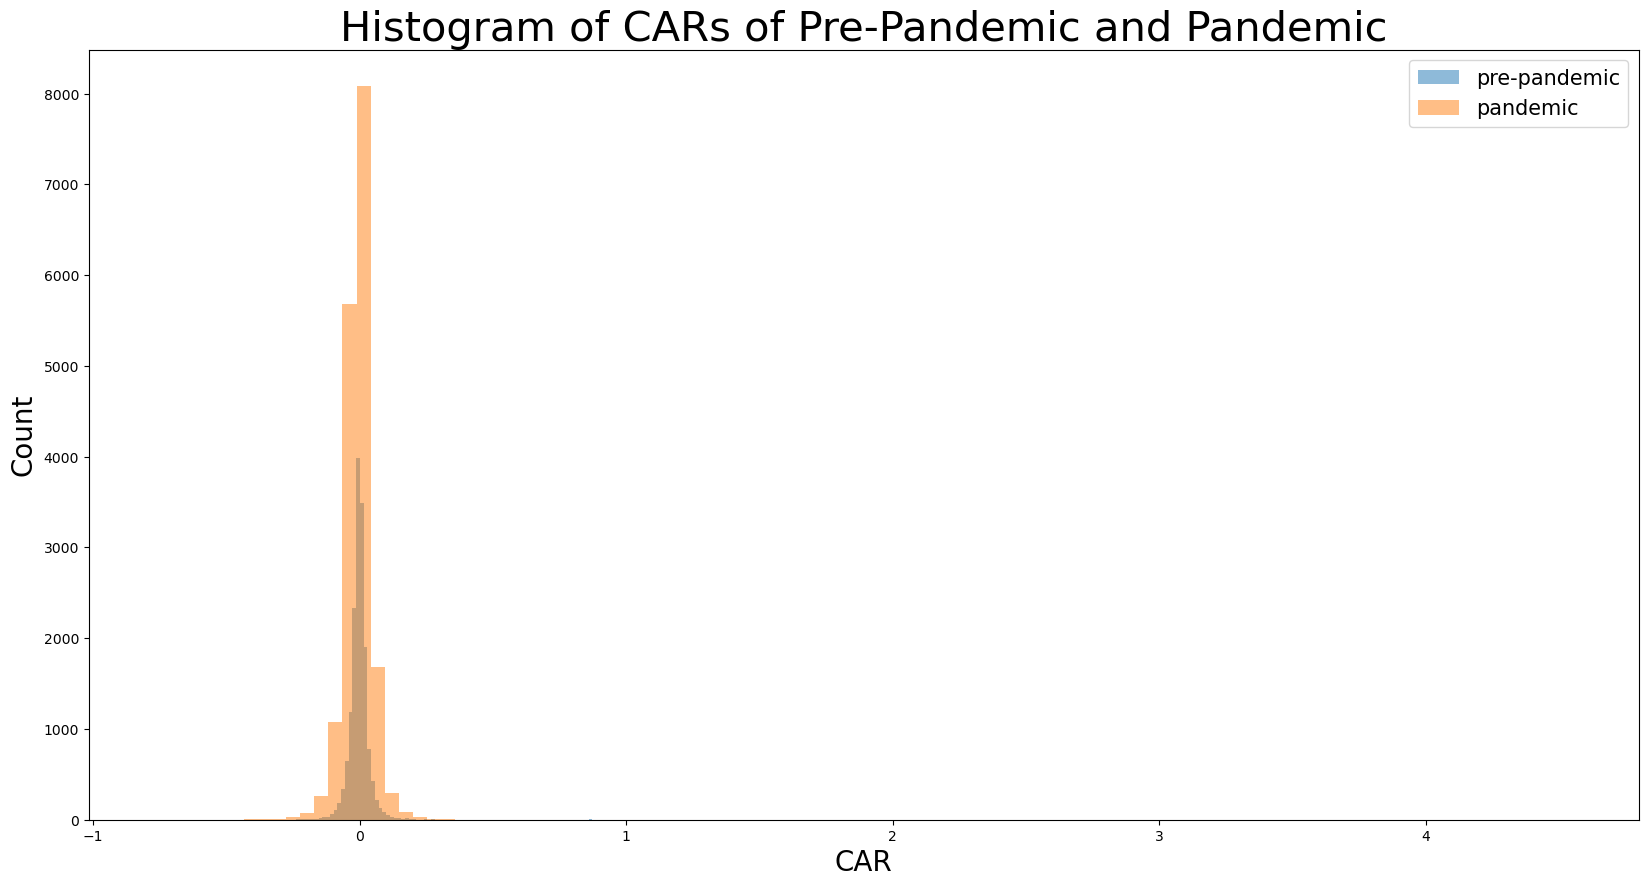

In [25]:
# ignore this approach for now, also because the sample lengths are different
ttest_results = []
ttest_index = []
from IPython.display import clear_output
for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)

        left, right = investigation_periods["Pre-Pandemic"]
        l_CAR, r_CAR = CAR_periods[cp]

        AR_prepandemic = df_abnormal_returns.loc[:,:,type_,left:right].values

        sample_CAR_prepandemic = AR_prepandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)
        # sample_CAR_prepandemic = R_market_event_window_prepandemic[:,l_CAR:(r_CAR+1)].cumsum(axis=1).mean(axis=0) ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST

        left, right = investigation_periods["Pandemic"]

        AR_pandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = AR_pandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)
        # sample_CAR_pandemic = R_market_event_window_pandemic[:,l_CAR:(r_CAR+1)].cumsum(axis=1).mean(axis=0) ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST
        # import ttest

        ttest = ttest_ind(sample_CAR_pandemic, sample_CAR_prepandemic)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((ttest.pvalue, ttest.statistic))
        ttest_index.append((type_, cp))


        fig = plt.figure(figsize=(fig_height, 10))
        plt.hist(sample_CAR_prepandemic,bins = 100, alpha = 0.5)
        plt.hist(sample_CAR_pandemic,bins = 100, alpha = 0.5)
        plt.legend(["pre-pandemic", "pandemic"], fontsize = tick_size)
        plt.xlabel("CAR", fontsize=label_size)
        plt.ylabel("Count", fontsize=label_size)
        plt.title("Histogram of CARs of Pre-Pandemic and Pandemic", fontsize=title_size)
        plt.savefig(f"data/{NAME}/visualisations/histogram_CARs_pp_p_{type_}_{cp}.svg")

        clear_output(wait=True)
        plt.show()

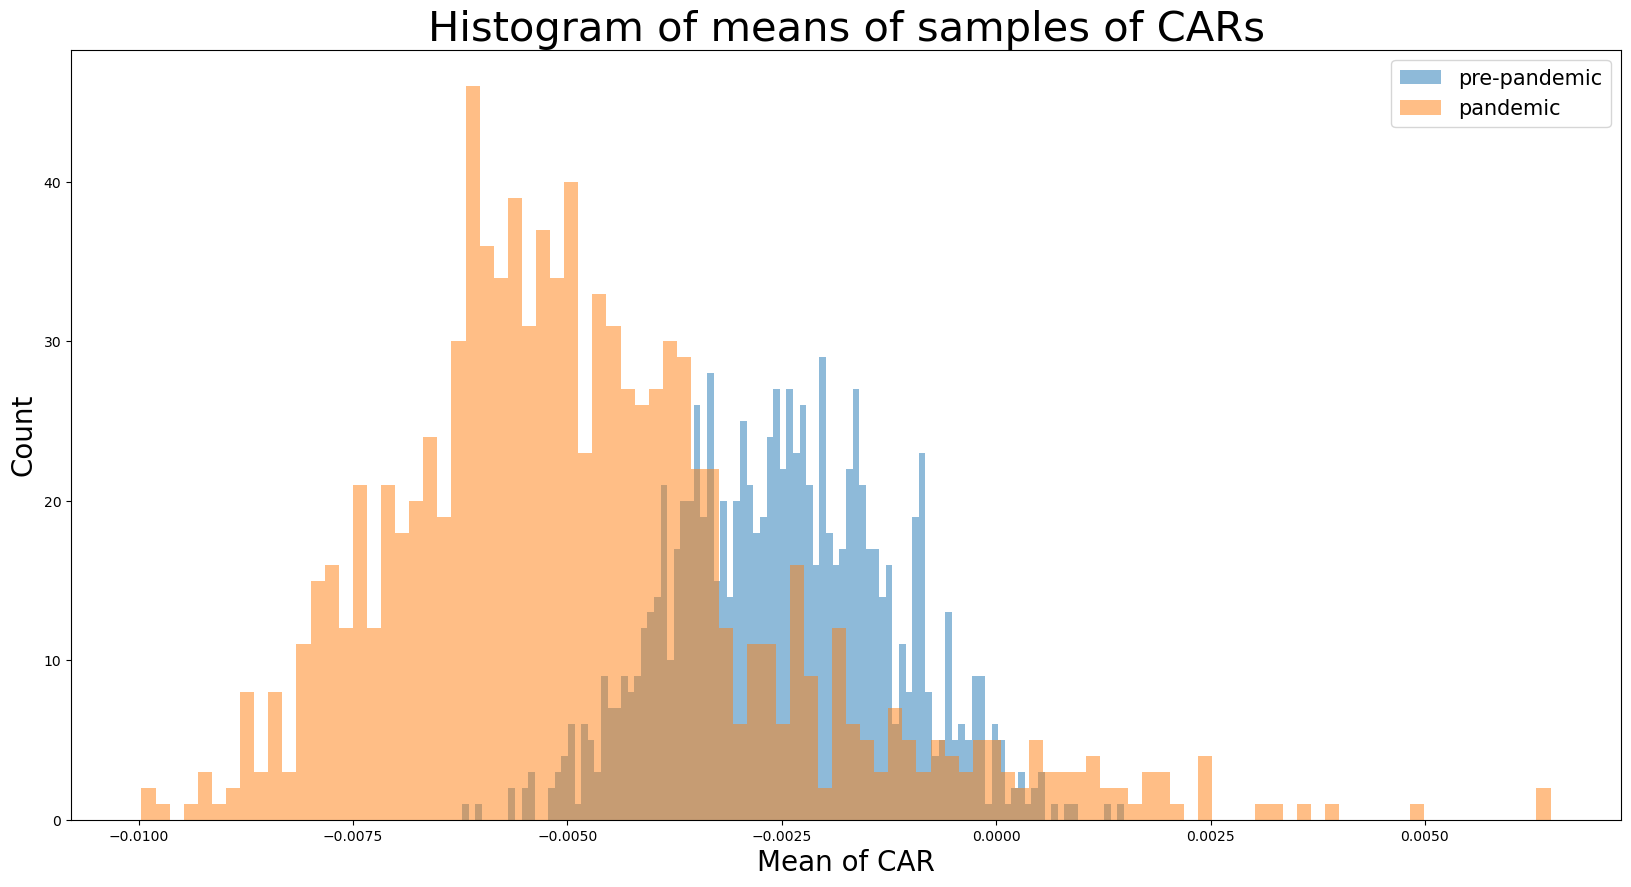

In [26]:
# approach recommended by Aussenegg: Simulate mean differences
ttest_results = []
ttest_index = []

for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)
        l_CAR, r_CAR = CAR_periods[cp]

        left, right = investigation_periods["Pre-Pandemic"]
        AR_prepandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_prepandemic = AR_prepandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)

        left, right = investigation_periods["Pandemic"]
        AR_pandemic = df_abnormal_returns.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = AR_pandemic[:,l_CAR:(r_CAR+1)].sum(axis=1)


        CAAR_pp = sample_CAR_prepandemic.mean()
        CAAR_p = sample_CAR_pandemic.mean()
        CAAR_diff = CAAR_p - CAAR_pp

        sample_size = 1000
        diffs = []
        subsample_means_CAR_prepandemic = []
        subsample_means_CAR_pandemic = []
        for i in range(1000):
            # pick subsample
            subsample_pp = np.random.choice(sample_CAR_prepandemic, sample_size, replace=True)
            subsample_p = np.random.choice(sample_CAR_pandemic, sample_size, replace=True)
            diff = subsample_p-subsample_pp
            subsample_means_CAR_prepandemic.append(subsample_pp.mean())
            subsample_means_CAR_pandemic.append(subsample_p.mean())
            diffs.append(diff.mean())



        fig = plt.figure(figsize=(fig_height, 10))
        plt.hist(subsample_means_CAR_prepandemic,bins = 100, alpha = 0.5)
        plt.hist(subsample_means_CAR_pandemic,bins = 100, alpha = 0.5)
        plt.legend(["pre-pandemic", "pandemic"], fontsize = tick_size)
        plt.xlabel("Mean of CAR", fontsize=label_size)
        plt.ylabel("Count", fontsize=label_size)

        plt.title("Histogram of means of samples of CARs", fontsize=title_size)
        plt.savefig(f"data/{NAME}/visualisations/histogram_mean_CARs_pp_p_{type_}_{cp}.svg")

        clear_output(wait=True)
        plt.show()

        ttest = stats.ttest_1samp(diffs, 0)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((CAAR_diff, ttest.pvalue, ttest.statistic))
        ttest_index.append((type_, cp))

In [27]:
ttest_df = pd.DataFrame(ttest_results, index=pd.MultiIndex.from_tuples(ttest_index, names=["Trade Type", "CAR period"]))
ttest_df.columns = ["Δ CAAR", "p-value", "t-statistic"]
print(ttest_df.round(10).to_latex())

\begin{tabular}{llrrr}
\toprule
            &        &    Δ CAAR &   p-value &  t-statistic \\
Trade Type & CAR period &           &           &              \\
\midrule
P - Purchase & [-20, -1] & -0.011382 &  0.000000 &   -32.053866 \\
            & [0, 20] &  0.008844 &  0.000000 &    32.640727 \\
            & [0, 5] &  0.003758 &  0.000000 &    22.165295 \\
            & [0, 1] &  0.006426 &  0.000000 &    54.279290 \\
S - Sale & [-20, -1] & -0.000973 &  0.001713 &    -3.144396 \\
            & [0, 20] & -0.011121 &  0.000000 &   -45.180535 \\
            & [0, 5] & -0.005581 &  0.000000 &   -46.939644 \\
            & [0, 1] & -0.003534 &  0.000000 &   -47.089041 \\
S - Sale+OE & [-20, -1] & -0.001016 &  0.001106 &    -3.271731 \\
            & [0, 20] & -0.012144 &  0.000000 &   -50.071691 \\
            & [0, 5] & -0.006211 &  0.000000 &   -51.216015 \\
            & [0, 1] & -0.002371 &  0.000000 &   -27.447692 \\
\bottomrule
\end{tabular}



C:\Users\waxfa\AppData\Local\Temp\ipykernel_29516\1209928904.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ttest_df.round(10).to_latex())


In [ ]:
test_results = []
test_index = []

for per in investigation_periods.keys():
    for type_ in types_of_interest:
        for CAR_period_name in CAR_periods.keys():

            print(per)
            print(type_)
            print(CAR_period_name)
            CAR_period = CAR_periods[CAR_period_name]

            left, right = investigation_periods[per]
            AR = df_abnormal_returns.loc[:,:,type_, left:right].values
            eps = df_eps.loc[:,:,type_,left:right].values
            R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
            R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
            grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, False)
            adj_grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
            CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
            test_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            #test_results.append((grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            test_index.append((per, type_, CAR_period_name))

Overall
P - Purchase
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 5]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 5]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale+OE
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations..

In [ ]:
test_results_df = pd.DataFrame(test_results, index=pd.MultiIndex.from_tuples(test_index, names=["Investigation Period", "Trade Type", "CAR Period"]))
test_results_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adj-GRANK p-value", "adj-GRANK statistic", "adjBMP p-value", "adjBMP t-statistic"]

In [ ]:
test_results_df.to_pickle(f"data/{NAME}/statistical_tests/GRANK_ADJBMP.pkl")

In [ ]:
test_results_df.to_excel(f"data/{NAME}/statistical_tests/statistical_tests_results.xlsx")

#### Export information to latex

In [ ]:
test_results_df